## Calibrate Camera in Rpi4

In [2]:
import cv2
import numpy as np
import os
import json
import glob 
import matplotlib.pyplot as plt 


In [3]:
output_folder = "data/data_calibration"
os.makedirs(output_folder, exist_ok=True)

cap = cv2.VideoCapture(0)  

if not cap.isOpened():
    print("Error al abrir la cámara.")
    exit()

print("Presiona 'c' para capturar una imagen, 'q' para salir.")

img_counter = 0

while True:
    ret, frame = cap.read()
    if not ret:
        print("No se pudo recibir el frame. Saliendo...")
        break

    cv2.imshow('Cámara', frame)

    key = cv2.waitKey(1)

    if key == ord('c'):  
        img_name = f"{output_folder}/calibration_image_{img_counter:03d}.png"
        cv2.imwrite(img_name, frame)
        print(f"Imagen guardada: {img_name}")
        img_counter += 1

    elif key == ord('q'):  
        print("Saliendo...")
        break


cap.release()
cv2.destroyAllWindows()


Presiona 'c' para capturar una imagen, 'q' para salir.


2025-01-03 13:11:53.828 python[40834:2871687] +[IMKClient subclass]: chose IMKClient_Modern
2025-01-03 13:11:53.828 python[40834:2871687] +[IMKInputSession subclass]: chose IMKInputSession_Modern


Imagen guardada: data/data_calibration/calibration_image_000.png


KeyboardInterrupt: 

: 

In [ ]:
def save_img(img, path, name):
    os.makedirs(path, exist_ok=True)
    cv2.imwrite(f"{path}/{name}.png", img)

2025-01-03 21:37:07.564 python[45873:3308211] +[IMKClient subclass]: chose IMKClient_Modern
2025-01-03 21:37:07.564 python[45873:3308211] +[IMKInputSession subclass]: chose IMKInputSession_Modern


Calibración completada.
Matriz de cámara:
[[968.50468791   0.         322.73275337]
 [  0.         963.51973801 253.25911335]
 [  0.           0.           1.        ]]
Coeficientes de distorsión:
[[-4.21320998e-02  7.36682368e-01  1.67063321e-04  7.73531360e-03
  -1.16145706e+00]]


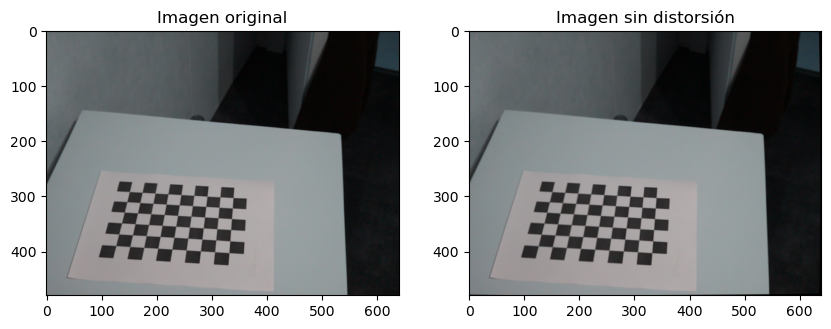

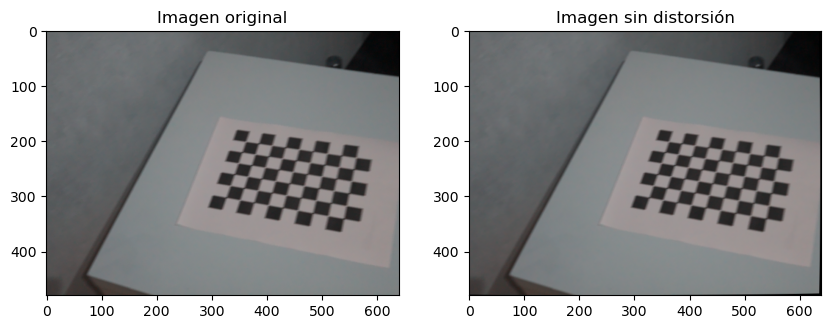

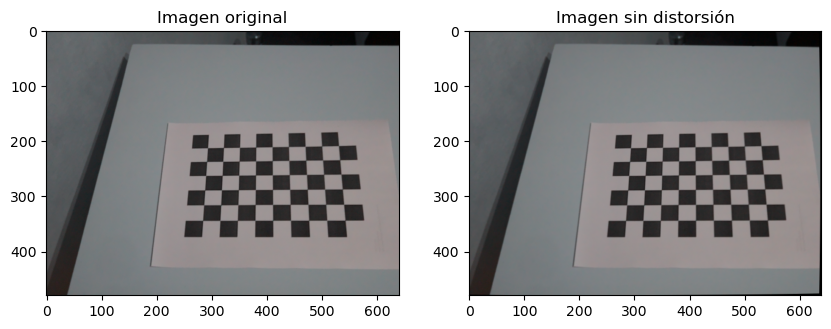

NameError: name 'output_folder' is not defined

: 

In [3]:
# Configuración del patrón de tablero de ajedrez
chessboard_size = (9, 6)  # Número de esquinas interiores del tablero de ajedrez
square_size = 2.0  # Tamaño de cada cuadrado en cm

# Preparar puntos del objeto en el espacio 3D
objp = np.zeros((chessboard_size[0] * chessboard_size[1], 3), np.float32)
objp[:, :2] = np.mgrid[0:chessboard_size[0], 0:chessboard_size[1]].T.reshape(-1, 2) * square_size

# Listas para almacenar puntos del objeto y puntos de la imagen
objpoints = []  # Puntos 3D en el espacio real
imgpoints = []  # Puntos 2D en el espacio de la imagen

# Leer imágenes de calibración
image_folder = "data/data_calibration"
images = glob.glob(f"{image_folder}/*.png")

if not images:
    print("No se encontraron imágenes en la carpeta.")
    exit()

# Procesar cada imagen
for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Buscar las esquinas del tablero de ajedrez
    ret, corners = cv2.findChessboardCorners(gray, chessboard_size, None)

    if ret:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Dibujar y mostrar las esquinas
        cv2.drawChessboardCorners(img, chessboard_size, corners, ret)
        cv2.imshow('Chessboard Corners', img)
        cv2.waitKey(500)

cv2.destroyAllWindows()

# Calibrar la cámara
if len(objpoints) > 0 and len(imgpoints) > 0:
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)

    if ret:
        print("Calibración completada.")
        print("Matriz de cámara:")
        print(mtx)
        print("Coeficientes de distorsión:")
        print(dist)

        # Función para corregir la distorsión
        def undistort_image(image, mtx, dist):
            return cv2.undistort(image, mtx, dist, None, mtx)

        # Mostrar imágenes originales y corregidas
        for fname in images[:3]:  # Limitar a las primeras 3 imágenes
            img = cv2.imread(fname)
            undistorted_img = undistort_image(img, mtx, dist)

            plt.figure(figsize=(10, 5))
            plt.subplot(1, 2, 1)
            plt.title("Imagen original")
            plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
            plt.subplot(1, 2, 2)
            plt.title("Imagen sin distorsión")
            plt.imshow(cv2.cvtColor(undistorted_img, cv2.COLOR_BGR2RGB))
            plt.show()

        # Guardar los parámetros de la cámara
        camera_params = {
            "camera_matrix": mtx.tolist(),
            "distortion_coefficients": dist.tolist()
        }

        with open(f"{output_folder}/camera_params.json", "w") as f:
            json.dump(camera_params, f, indent=4)

        print("Parámetros de la cámara guardados en 'camera_params.json'.")
    else:
        print("Error en la calibración.")
else:
    print("No se encontraron suficientes puntos para la calibración.")
